# 20新卒データベース研修: Apache Spark入門

クラスタコンピューティングプラットフォーム Apache Spark (以後Spark) とはどのようなものか学んでみましょう。

## Sparkとは

Sparkとは並列分散処理を行うための汎用的なプラットフォームです。  
SQLやテキスト処理、機械学習といった異なる種類の処理を簡単に組み合わせられるのが特徴となっています。

## 環境構築

### PySparkインストール

In [0]:
!pip install pyspark

### 環境変数設定

In [0]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## Hello, world!

ユーザーが実際に記述するプログラムはドライバプログラムと呼ばれており、このプログラムを起点に処理が走ります。　

ドライブプログラムからSparkの分散リソースにアクセスするのに必要な `SparkContext` を生成してみましょう。

In [0]:
from pyspark import SparkConf, SparkContext

# setMaster('local[*]'): クラスタのURLを設定 (ローカル (Colaboratory) 上で実行)
# setAppName('my app'): アプリケーション名を設定 (任意)
conf = SparkConf().setMaster('local[*]').setAppName('my app')
sc = SparkContext(conf=conf)

次に`SparkContext` を使ってRDD (耐障害性分散データセット) を構築してみましょう。

RDD (耐障害性分散データセット) とは、複数のコンピュートノードに跨って配置されているデータのコレクションであり、Sparkの全ての操作はRDDに対して行います。  
ここでは、Colaboratoryにデフォルトで入っているサンプルデータのREADMEからRDDを生成してみます。

In [0]:
lines = sc.textFile('sample_data/README.md')

なお、READMEの中身は以下のようになっています。

In [0]:
!cat sample_data/README.md

以下のようにすると、READMEからURLを含む行のみを取得できます。

In [0]:
# URLを含む行のみに絞り込む
url_lines = lines.filter(lambda s: 'http' in s)

# URLを含む行を取得
url_lines.collect()

## RDD (耐障害性分散データセット) 

### 基本

先述の通り、RDD (耐障害性分散データセット) とは、複数のコンピュートノードに跨って配置されているデータのコレクションです。  
RDDは複数のパーティションに分割されており、各パーティションに対する処理がクラスタ内の各ノード上で実行されます。

#### RDDを生成する方法

* 外部のデータセットをロードする
  * Hello, world! で行なった `filter` が該当

* リストや集合等のプログラム内にあるデータを各ノードに配置する
  * 1台のマシンにデータセットを全て持つ必要があるため、小規模なデータを用いたプロトタイピングで使われることが多い

In [0]:
data = sc.parallelize(['hoge', 'fuga', 'foo', 'bar'])

#### RDDに対して行える操作

* 変換
   * あるRDDから新しいRDDを構築する処理
   * Hello, world! で行なったURLを含む行を絞り込み処理が該当
   * __初めてアクションが実行された時点で実行される (詳細後述)__
* アクション
   * RDDを元に結果を計算する処理
   * 結果をドライバプログラムに戻す処理
     * Hello, world! で行なった `collect` が該当
   * 結果を外部のストレージシステムに保存する処理


#### 変換がすぐ実行されない (初めてアクションが実行された時点で実行される) 理由

変換がすぐ実行されないのは必要なデータのみを取り込んで処理を行うためです。  
Hello, world! の例で考えてみると、READMEからURLを含む行だけ読み込めば処理が成り立ちますが、逐次実行される場合、一旦全ての行を読み込んでから処理を行うことになります。  
今回の場合はデータ量が多くないのでそれでも問題ありませんが、これが何万行もある文書だった場合、ストレージを無駄に消費することになってしまいます。  
このようなことを防ぐため、変換はすぐ実行されないのです。

#### 永続化

RDDはそれに対するアクションが実行される度に計算し直されます。  
もし、RDDを何度もアクションで利用するのであれば、 `persist` で永続化を行います。  

In [0]:
lines.persist()

永続化を行うと、メモリやディスク等のストレージにデータが保存され、それ以降のアクションでは保存されたデータを使用します。　

なお、永続化がデフォルトで有効になっていないのは、RDDで1度しかアクションを実行しないのであればデータをストレージに保存する必要がなく、保存しない方が容量を削減できるためです。

### RDDの操作

#### 変換

RDDに対して変換を行うと新しいRDDが返されます。  
例えば、以下の `lines` と `url_lines` は別のRDDとなります。

In [0]:
lines = sc.textFile('sample_data/README.md')
url_lines = lines.filter(lambda s: 'http' in s)

`lines` は他の変換処理を行う際に再利用できます。  
従って、以下のようにCSVのファイル名を含む行を抽出するために `lines` を再利用することが可能です。

In [0]:
csv_lines = lines.filter(lambda s: '.csv' in s)

変換によって新たなRDDを生成するたびにSparkでは系統グラフと呼ばれるRDD間の依存関係を保持していきます (下図参照)。  
系統グラフはRDDの計算を行なったり、永続化されたRDDに欠損が生じたときにデータを回復させたりする際に使用されます。

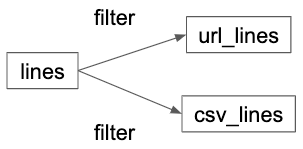

なお、変換処理は遅延し、アクションで使用する際に初めて実行されます。

#### アクション

変換ではRDDから新たなRDDを生成しましたが、この後RDDに対して何かしらの処理を行うことになります。この処理をアクションと言います。  
具体的にはドライバプログラムに値を返したり、データをストレージに書き出したりする処理がアクションに該当します。  
RDDに対してアクションを行うと、実際に出力を生成しないといけないため、そのRDDが必要とする変換処理が実行されます。

アクションの例として、変換の節で生成した `url_lines` と `csv_lines` の内容を出力してみましょう。

In [0]:
# 例で表示する行数
n = 10

In [0]:
print(f'URLを含む行数: {url_lines.count()}')
print(f'<例 ({n}件)>')
for line in url_lines.take(n):
  print(line)

In [0]:
print(f'URLを含む行数: {csv_lines.count()}')
print(f'<例 ({n}件)>')
for line in csv_lines.take(n):
  print(line)

ここでは要素の個数を返す `count` と複数の要素を取得する `take` という2つのアクションを使用しています。  
`take` に類似したアクションとして全ての要素を取得する `collect` もありますが (Hello, world! で使用)、このアクションを使用する場合はドライバプログラム側のマシンのメモリにデータセットが全て収まる必要があります。  
従って、大きなデータセットに対しては `collect` 等を使用してドライバプログラム側に持ってくるのではなく、ストレージシステムに書き出すのが一般的です。

なお、アクションを実行するたびに使用されるRDD全体が計算され直されます。  
そのため、同じRDDに対して何度もアクションを実行する場合はRDDに対して永続化を行います。

#### 遅延評価

RDDに対する変換の評価は遅延します。すなわち、アクションが実行されるまで変換処理を行いません。  
具体的にどういうことかというと、RDDに対する変換を呼び出したとき、変換処理を実行する代わりに、その処理が要求されたことを示すメタデータを内部的に記録します。  

これにより、処理全体を見渡した上で、データセットに対する処理の回数を減らして実行することが可能になっています。  
処理回数の削減は内部的に行われるため、ユーザーは変換処理の効率化に労力を割かなくても良くなっています。

## SparkSQL

SparkSQLとは構造化データや半構造化データを扱うためのインターフェイスです。

### 初期化

`SparkContext` を元に `HiveContext` を構築し、 `HiveContext`　を起点に処理を行なっていきます。

In [0]:
from pyspark import HiveContext

hive_sc = HiveContext(sc)

### 基本的なクエリ

`sample_data/california_housing_train.csv` からデータを10件取得する処理を例に、基本的な流れを見てみましょう。

まず、 `sample_data/california_housing_train.csv` を読み込み、SpqrkSQL用の特殊な `RDD` である `DataFrame` を作成します。

In [0]:
housing = hive_sc.read.option('header', True).csv('sample_data/california_housing_train.csv')

次に `DataFrame` をSparkSQLのView `housing` として登録します。

In [0]:
housing.createOrReplaceTempView('housing')

そして登録したView `housing` に対してクエリを実行します。

In [0]:
housing_part = hive_sc.sql('SELECT * FROM housing LIMIT 10')

`DataFrame` の内容を取得してみると、10件取得できていることがわかります。

In [0]:
# showでDataFrameの内容を取得できる
housing_part.show()

## 演習問題

### 準備

In [0]:
# データ取得
!git clone https://github.com/databricks/learning-spark

### 特定の条件を満たすデータの件数を数える

`learning-spark/files/fake_logs/log1.log` に記録されている `71.19.157.174` からのアクセス回数を数えてみましょう。

<ヒント>
* `sc.textFile`: テキストファイルを読み込み、RDDを生成する
* `filter`: データを絞り込む変換 (条件を満たすとき `True` を返すラムダ式や関数を引数に取る)
* `count`: データの件数を数えるアクション

In [0]:
# ログデータの内容
!cat learning-spark/files/fake_logs/log1.log

In [0]:
# ここにプログラムを記述する


### データに対し変換を行い、その最小値, 最大値を取得する

`learning-spark/files/fake_logs/log1.log` に記録されている `71.19.157.174` からの最初のアクセスと最後のアクセスの日時を取得しましょう。

<ヒント>
* `map`: RDDの各要素に対し、引数で与えたラムダ式・関数を適用する変換
* `min`: 最小値を返すアクション
* `max`: 最大値を返すアクション

In [0]:
# ここにプログラムを記述する


### 片方のRDDに含まれる要素を除外する

`sample_data/README.md` から以下のRDDを作成します。
* `url_lines`: URLを含む行を抽出したRDD
* `mnist_lines`: `mnist`, `MNIST` を含む行を抽出したRDD

`url_lines` から `mnist_lines` を除外した (URLを含む行のうち、`mnist`, `MNIST` を含む行を除外した) データを取得しましょう。

<ヒント>
* `rdd_a.subtract(rdd_b)`: `rdd_a` から `rdd_b` に含まれる要素を除外する変換
* `collect`: RDDの全要素を取得するアクション
* `str.upper`: 文字列を大文字化する (Python標準の関数)
* `str.lower`: 文字列を小文字化する (Python標準の関数)

In [0]:
# sample_data/README.mdの内容
!cat sample_data/README.md

In [0]:
# ここにプログラムを記述する


### RDDによる処理とSparkSQLを用いた処理の違い

`sample_data/california_housing_train.csv` を読み込み、 `population` の最大値を取得してみましょう。

#### 通常のRDDで行う場合

In [0]:
# ここにプログラムを記述する


#### SparkSQLで行う場合

<ヒント>
* `MAX(column)`: `column` の最大値を取る (SparkSQL)

In [0]:
# ここにプログラムを記述する


## 参考文献

* Holden Karau, Andy Konwinski, Patrick Wendell, Matei Zaharia (著), 玉川竜司 (訳), 初めてのSpark, 株式会社オライリー・ジャパン  
( https://www.amazon.co.jp/%E5%88%9D%E3%82%81%E3%81%A6%E3%81%AESpark-Holden-Karau/dp/4873117348 )